 ## BAF Veri Setinden GAN ile Yapay Veri Üretimi

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import time

C:\Users\Beyza\anaconda3\anacondaa3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Beyza\anaconda3\anacondaa3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv('base.csv')  
data = pd.read_csv('base.csv') 

categorical_columns = ['income', 'customer_age', 'payment_type', 'employment_status', 'housing_status', 'source', 'device_os', 'device_distinct_emails_8w', 'device_fraud_count', 'month']  

encoder = OneHotEncoder(sparse=False, drop='first')
encoded_df = pd.DataFrame(encoder.fit_transform(df[categorical_columns]))

encoded_df.columns = encoder.get_feature_names_out(categorical_columns)

df = df.drop(columns=categorical_columns) 
df = pd.concat([df, encoded_df], axis=1)  

columns_to_scale = df.columns

scaler = StandardScaler()
scaled_df = df.copy()
scaled_df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [3]:
latent_dim = 100
num_epochs = 100
batch_size = 64

class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),  # Daha fazla nöron
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),  # Daha derin bir model için katman ekleme
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),  # Daha geniş bir katman
            nn.ReLU(),  # ReLU kullanımı
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator(input_dim=latent_dim, output_dim=scaled_df.shape[1]).to(device)
discriminator = Discriminator(input_dim=scaled_df.shape[1]).to(device)

# Optimizasyon parametrelerini düzenleme
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
criterion = nn.BCELoss()

data_tensor = torch.tensor(scaled_df.values, dtype=torch.float32).to(device)
train_loader = DataLoader(TensorDataset(data_tensor), batch_size=batch_size, shuffle=True)

def train_model():
    start_time = time.time()
    for epoch in range(num_epochs):
        for real_data in train_loader:
            real_data = real_data[0]

            batch_size = real_data.size(0)
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            optimizer_d.zero_grad()
            outputs = discriminator(real_data)
            d_loss_real = criterion(outputs, real_labels)
            d_loss_real.backward()

            z = torch.randn(batch_size, latent_dim).to(device)
            fake_data = generator(z)
            outputs = discriminator(fake_data.detach())
            d_loss_fake = criterion(outputs, fake_labels)
            d_loss_fake.backward()
            optimizer_d.step()

            optimizer_g.zero_grad()
            outputs = discriminator(fake_data)
            g_loss = criterion(outputs, real_labels)
            g_loss.backward()
            optimizer_g.step()

        print(f'Epoch [{epoch+1}/{num_epochs}] | D Loss: {d_loss_real.item() + d_loss_fake.item()} | G Loss: {g_loss.item()}')
    
    end_time = time.time()
    return end_time - start_time

if device.type == 'cuda':
    gpu_time = train_model()
    print(f"GPU eğitim süresi: {gpu_time:.2f} saniye")
else:
    cpu_time = train_model()
    print(f"CPU eğitim süresi: {cpu_time:.2f} saniye")



Epoch [1/100] | D Loss: 5.459858272161e-07 | G Loss: 14.481359481811523
Epoch [2/100] | D Loss: 3.933948664780473e-05 | G Loss: 11.044889450073242
Epoch [3/100] | D Loss: 1.3134784140333977e-06 | G Loss: 13.846508026123047
Epoch [4/100] | D Loss: 1.0173666353807675e-08 | G Loss: 18.42102813720703
Epoch [5/100] | D Loss: 2.118115573879198e-06 | G Loss: 22.581439971923828
Epoch [6/100] | D Loss: 6.146734678875117e-08 | G Loss: 38.24259948730469
Epoch [7/100] | D Loss: 6.6078051474960375e-06 | G Loss: 19.330032348632812
Epoch [8/100] | D Loss: 2.2215084527488216e-06 | G Loss: 16.635128021240234
Epoch [9/100] | D Loss: 4.3593114051193593e-07 | G Loss: 41.62425231933594
Epoch [10/100] | D Loss: 1.3224790507138098e-07 | G Loss: 61.80141067504883
Epoch [11/100] | D Loss: 1.2219047675899033e-06 | G Loss: 51.8153190612793
Epoch [12/100] | D Loss: 7.450693148227194e-07 | G Loss: 59.497154235839844
Epoch [13/100] | D Loss: 2.7939680791178034e-08 | G Loss: 73.40277099609375
Epoch [14/100] | D Los

In [4]:
num_samples = 10000
noise = torch.randn(num_samples, latent_dim)

generated_data = generator(noise).detach().numpy()

generated_df = pd.DataFrame(generated_data, columns=scaled_df.columns)

generated_df[columns_to_scale] = scaler.inverse_transform(generated_df[columns_to_scale])

categorical_output = pd.DataFrame(encoder.inverse_transform(generated_df[encoded_df.columns]))
categorical_output.columns = categorical_columns

generated_df = generated_df.drop(columns=encoded_df.columns)
generated_df = pd.concat([generated_df, categorical_output], axis=1)

In [5]:
generated_df.head()

,fraud_bool,name_email_similarity,prev_address_months_count,current_address_months_count,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,...,income,customer_age,payment_type,employment_status,housing_status,source,device_os,device_distinct_emails_8w,device_fraud_count,month
0,-0.093409,0.782819,60.764774,-1.818688,-4.356127,-11.574647,2578.066162,8674.675781,3290.570068,3936.480469,...,0.8,40,AB,CF,BB,TELEAPP,windows,1,0,4
1,0.115467,0.204569,60.764774,174.994415,6.407537,-11.574647,2578.066162,8674.675781,6248.993652,5776.167480,...,0.9,30,AD,CC,BC,TELEAPP,macintosh,1,0,3
2,0.115467,0.204569,-27.327639,174.994415,6.407537,-11.574647,567.317993,2655.917480,6248.993652,5776.167480,...,0.9,30,AE,CB,BC,TELEAPP,macintosh,1,0,3
3,0.115467,0.782819,60.764774,174.994415,-4.356127,-11.574647,2578.066162,8674.675781,3290.570068,5776.167480,...,0.4,30,AD,CC,BG,TELEAPP,windows,1,0,4
4,-0.093409,0.782819,60.764774,-1.818688,-4.356127,-11.574647,2578.066162,8674.675781,3290.570068,3936.480469,...,0.8,40,AB,CF,BB,TELEAPP,windows,1,0,4


In [6]:
generated_df['fraud_bool'].mode()

0   -0.093409
Name: fraud_bool, dtype: float32

In [7]:
df_sorted = generated_df.sort_values(by='fraud_bool', ascending=False).reset_index()

df_sorted.loc[:9999, 'fraud_bool'] = 1  
df_sorted.loc[10000:, 'fraud_bool'] = 0  

generated_df['fraud_bool'] = df_sorted.sort_values(by='index').reset_index(drop=True)['fraud_bool']

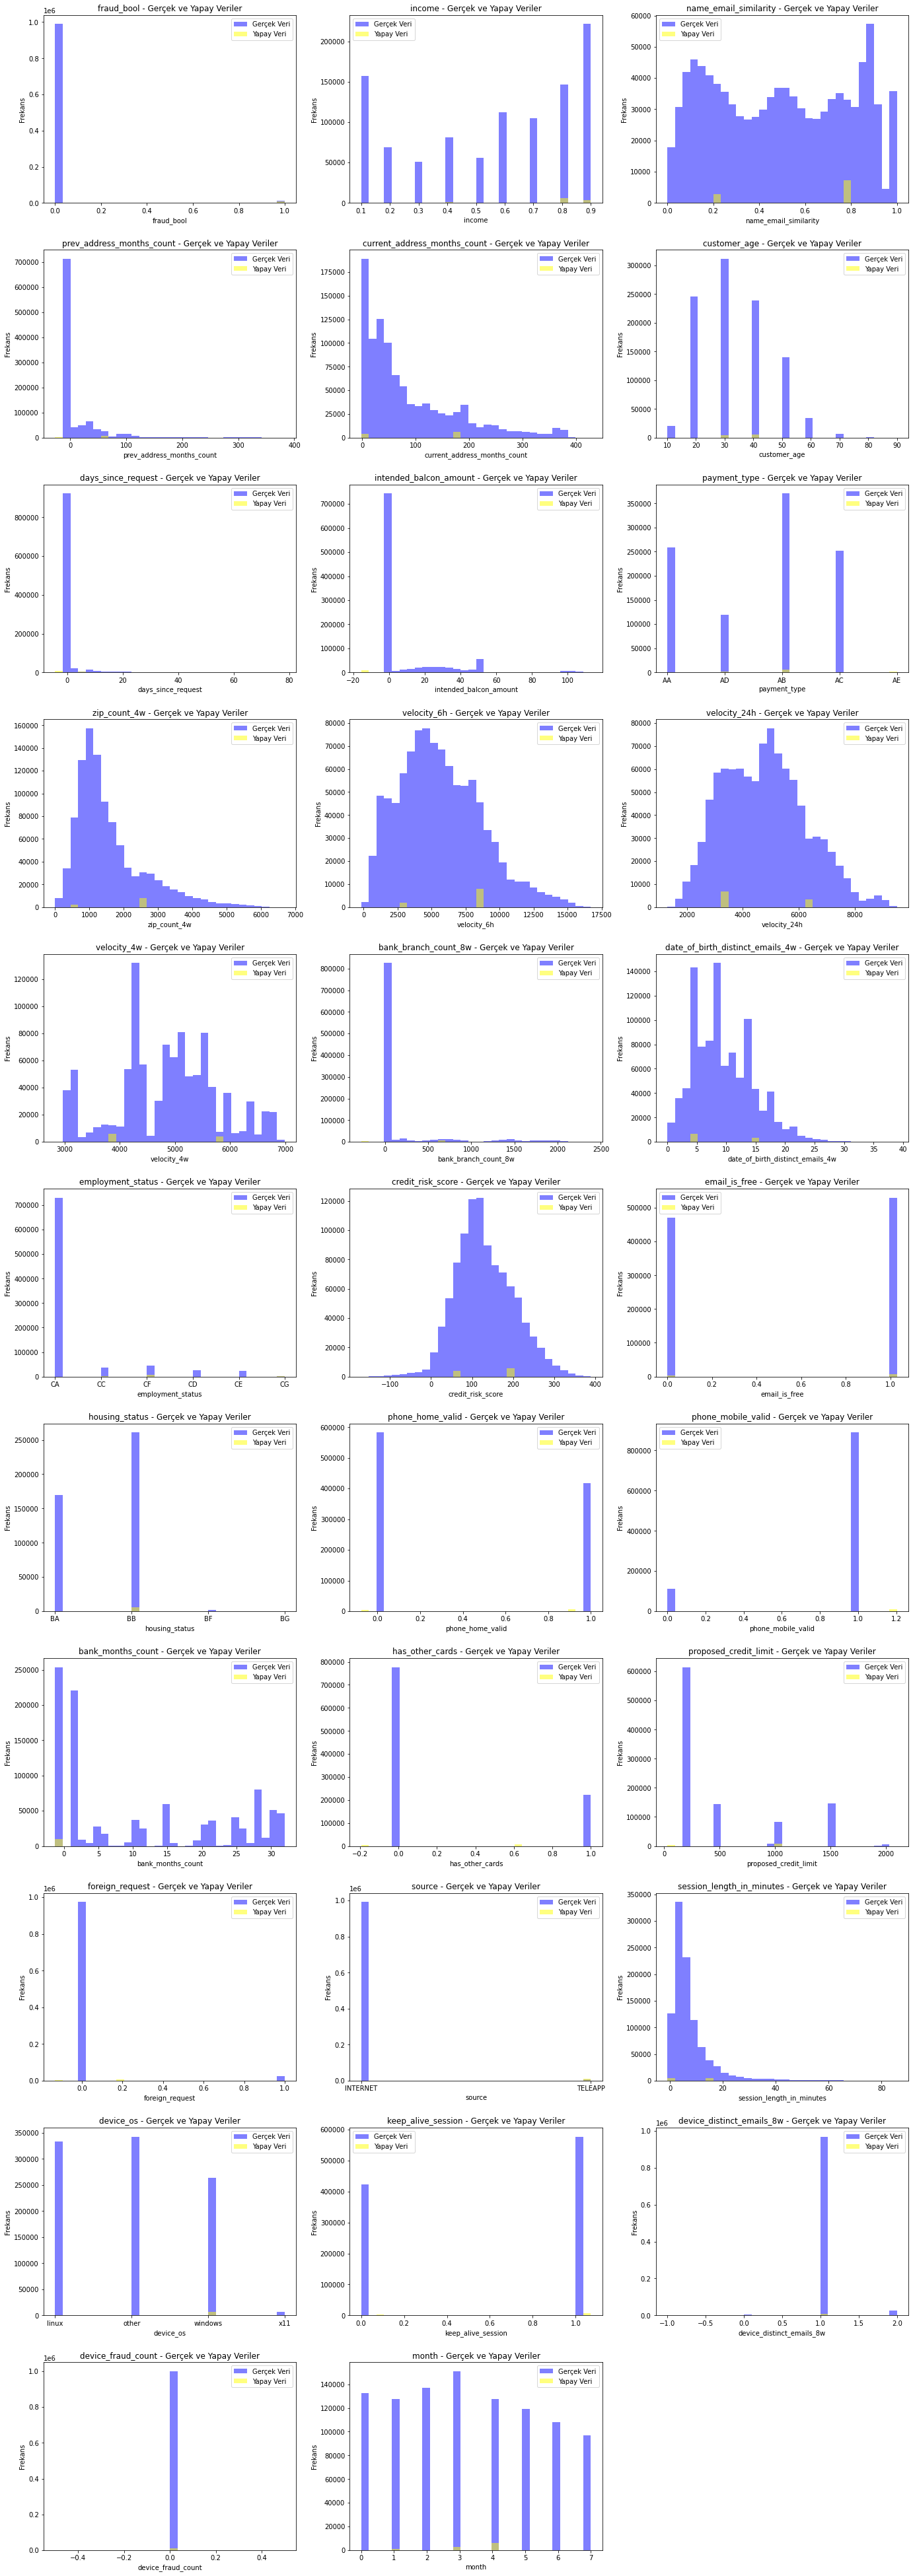

In [8]:
df = data

features = df.columns

num_features = len(features)
num_columns = 3
num_rows = (num_features + num_columns - 1) // num_columns  

fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 5))
fig.tight_layout(pad=5.0)  

for i, feature in enumerate(features):
    row = i // num_columns
    col = i % num_columns
    
    ax = axes[row, col]
    
    min_val = min(df[feature].min(), generated_df[feature].min())
    max_val = max(df[feature].max(), generated_df[feature].max())
    
    ax.hist(df[feature], bins=30, alpha=0.5, label='Gerçek Veri', color='blue', range=(min_val, max_val))
    ax.hist(generated_df[feature], bins=30, alpha=0.5, label='Yapay Veri', color='yellow', range=(min_val, max_val))
    
    ax.set_title(f'{feature} - Gerçek ve Yapay Veriler')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frekans')
    ax.legend()

for j in range(len(features), num_rows * num_columns):
    fig.delaxes(axes[j // num_columns, j % num_columns])

plt.show()

In [9]:
num_samples = 1000000
noise = torch.randn(num_samples, latent_dim)

generated_data = generator(noise).detach().numpy()

generated_df = pd.DataFrame(generated_data, columns=scaled_df.columns)

generated_df[columns_to_scale] = scaler.inverse_transform(generated_df[columns_to_scale])

categorical_output = pd.DataFrame(encoder.inverse_transform(generated_df[encoded_df.columns]))
categorical_output.columns = categorical_columns

generated_df = generated_df.drop(columns=encoded_df.columns)
generated_df = pd.concat([generated_df, categorical_output], axis=1)

In [10]:
df_sorted = generated_df.sort_values(by='fraud_bool', ascending=False).reset_index()

df_sorted.loc[:9999, 'fraud_bool'] = 1  
df_sorted.loc[10000:, 'fraud_bool'] = 0  

generated_df['fraud_bool'] = df_sorted.sort_values(by='index').reset_index(drop=True)['fraud_bool']

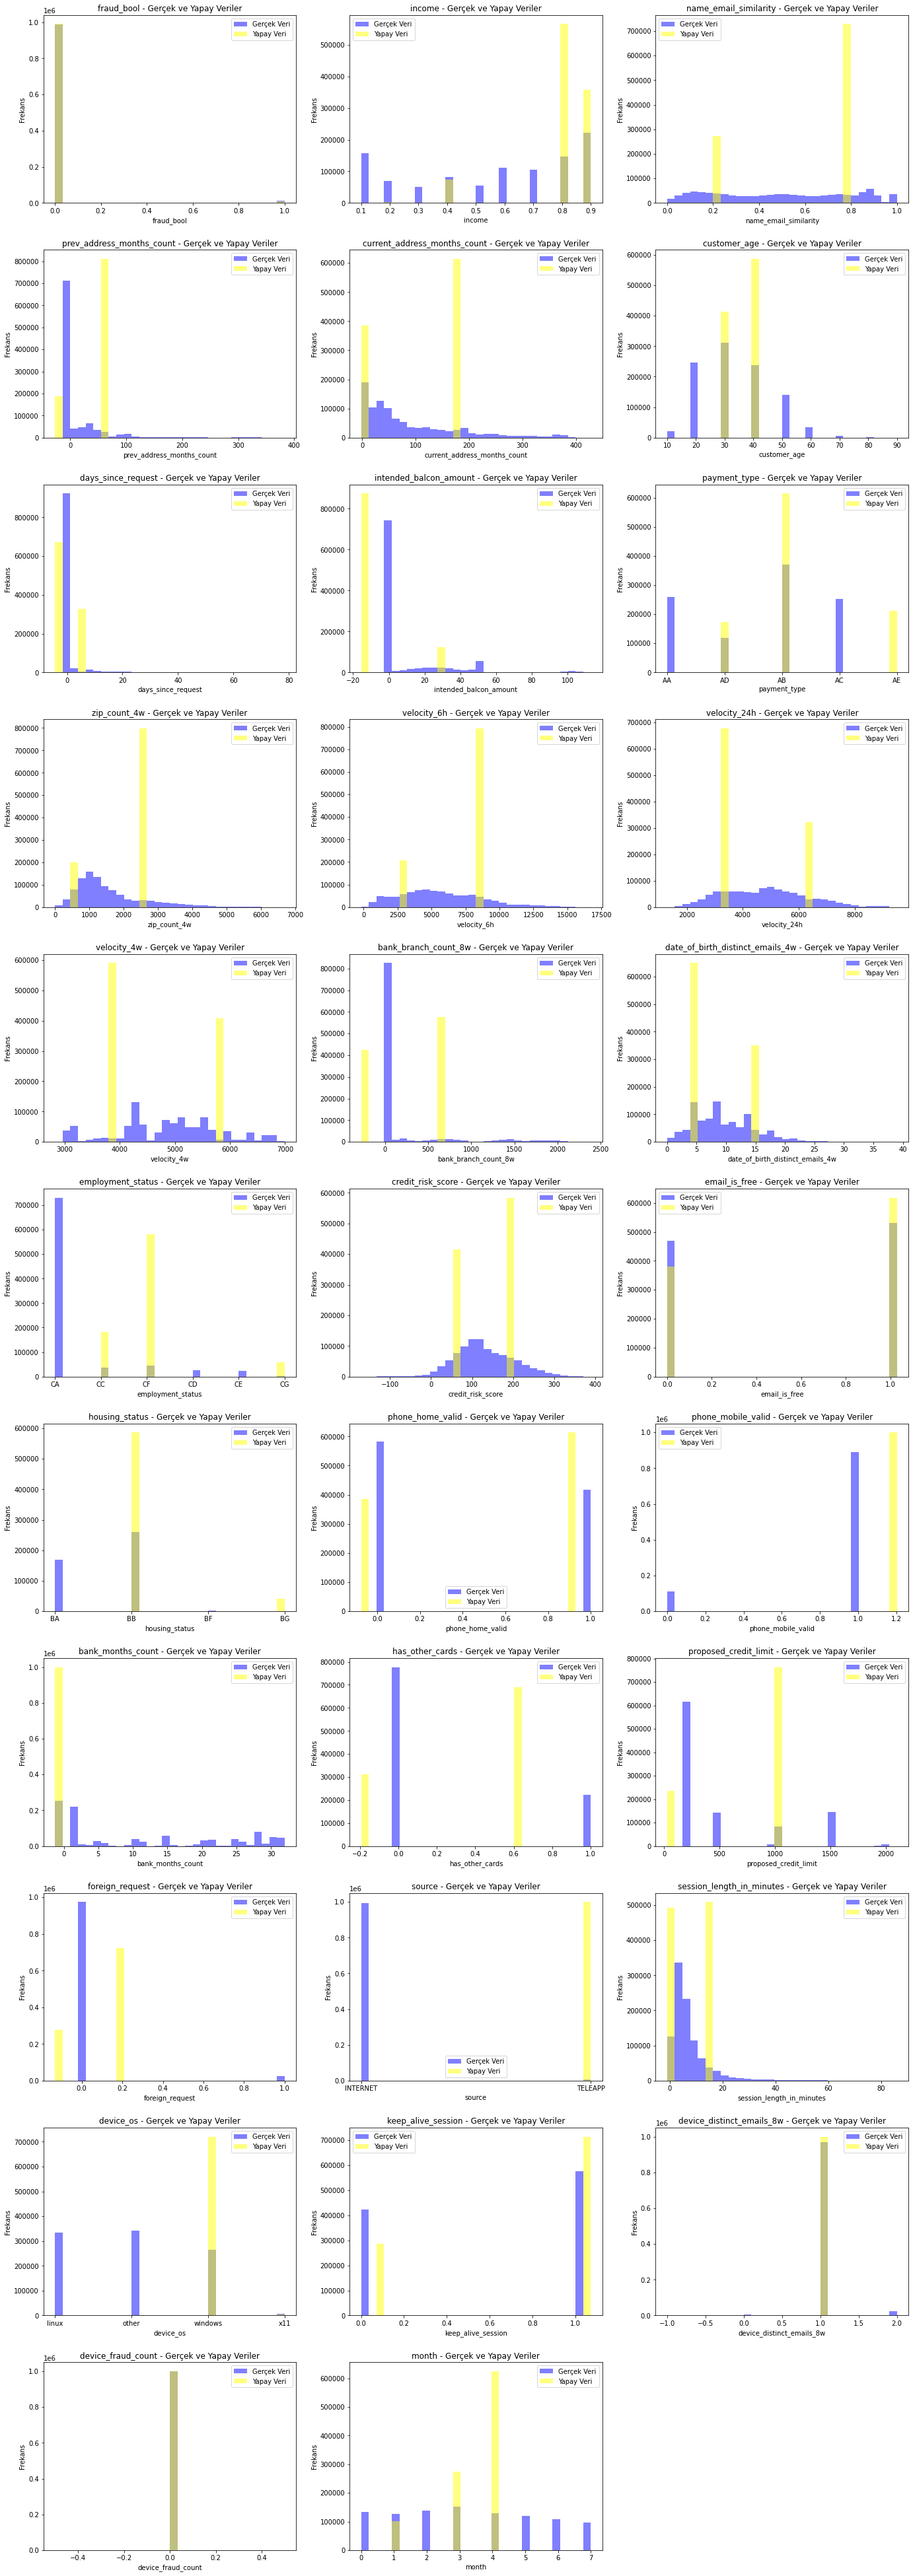

In [11]:
df = data

features = df.columns

num_features = len(features)
num_columns = 3
num_rows = (num_features + num_columns - 1) // num_columns  

fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 5))
fig.tight_layout(pad=5.0)  

for i, feature in enumerate(features):
    row = i // num_columns
    col = i % num_columns
    
    ax = axes[row, col]
    
    min_val = min(df[feature].min(), generated_df[feature].min())
    max_val = max(df[feature].max(), generated_df[feature].max())
    
    ax.hist(df[feature], bins=30, alpha=0.5, label='Gerçek Veri', color='blue', range=(min_val, max_val))
    ax.hist(generated_df[feature], bins=30, alpha=0.5, label='Yapay Veri', color='yellow', range=(min_val, max_val))
    
    ax.set_title(f'{feature} - Gerçek ve Yapay Veriler')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frekans')
    ax.legend()

for j in range(len(features), num_rows * num_columns):
    fig.delaxes(axes[j // num_columns, j % num_columns])

plt.show()